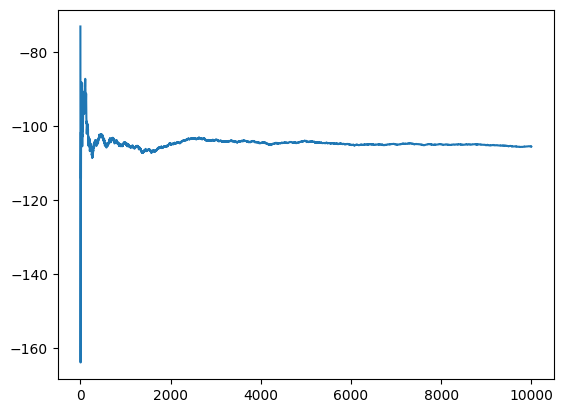

In [2]:
#Task 1.1
from time import sleep
from typing import Optional
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
from commons import AbstractAgent, AbstractRLTask, get_crop_chars_from_observation
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import display

class GridWorld(gym.Env):
    metadata = {'render_modes': ['human', 'rgb_array']}
    reward_range = (-float("inf"), float("inf"))
    spec = None

    def __init__(self, n, m):
        super(GridWorld, self).__init__()
        self.n = n
        self.m = m
        self.action_space = spaces.Discrete(4)  # Up, Down, Right, Left
        self.observation_space = spaces.Tuple((spaces.Discrete(n), spaces.Discrete(m)))

        # Agent starts at (0, 0) and goal is at (n-1, m-1)
        self.position = (0, 0)
        self.goal = (n - 1, m - 1)

    #Run one timestep of the environment's dynamics. 
    #When end of episode is reached, you are responsible for calling `reset()` to reset this environment's state.
    def step(self, action):
        # Dictionary mapping actions to movements
        actions = {
            0: (-1, 0),  # Up
            1: (1, 0),   # Down
            2: (0, 1),   # Right
            3: (0, -1)   # Left
        }

        # Perform action
        movement = actions[action]
        new_position = (self.position[0] + movement[0], self.position[1] + movement[1])

        # Check if new position is within grid
        if 0 <= new_position[0] < self.n and 0 <= new_position[1] < self.m:
            self.position = new_position
           
        #observation (object): agent's observation of the current environment    
        observation = self
        
        #reward (float) : amount of reward returned after previous action
        reward = -1
        
        #done (bool): whether the episode has ended, in which case further step() calls will return undefined results
        done = self.position == self.goal
        
        #info (dict): contains auxiliary diagnostic information (helpful for debugging, logging, and sometimes learning)
        info = []

        return (observation, reward, done, info)

    #Resets the environment to an initial state and returns an initial observation.
    def reset(self,*, seed: Optional[int] = None, return_info: bool = False, 
              options: Optional[dict] = None):

        # Initialize the RNG if the seed is manually passed
        if seed is not None:
           self._np_random, seed = seeding.np_random(seed)

        self.position = (0,0)
        observation = self

        #info (optional dictionary): a dictionary containing extra information
        #this is only returned if return_info is set to true
        info = []

        if return_info:
            return observation, info
        return observation

    def render(self, mode="human"):
        """Renders the environment.

        The set of supported modes varies per environment. (And some
        third-party environments may not support rendering at all.)
        By convention, if mode is:

        - human: render to the current display or terminal and
          return nothing. Usually for human consumption.
        - rgb_array: Return an numpy.ndarray with shape (x, y, 3),
          representing RGB values for an x-by-y pixel image, suitable
          for turning into a video.
        - ansi: Return a string (str) or StringIO.StringIO containing a
          terminal-style text representation. The text can include newlines
          and ANSI escape sequences (e.g. for colors).
        """


        if mode == 'rgb_array':
            # Render the grid world as an RGB array
            rgb_array = np.zeros((self.n, self.m, 3), dtype=np.uint8)
            rgb_array[self.position] = [255, 0, 0]  # Red color for agent
            rgb_array[self.goal] = [0, 255, 0]   # Green color for goal

            return rgb_array
        
        # Initialize the ANSI character array
        ansi_grid = np.full((self.n, self.m), '.', dtype=str)  # Fill with '.'

        # Place the agent and goal
        ansi_grid[self.position] = '@'  # Agent
        ansi_grid[self.goal] = '>'  # Goal

        #ansi_grid = '\n'.join([''.join(row) for row in ansi_grid])
        
        if mode == 'ansi':
            return ansi_grid
        
        elif mode == 'human':
            print('\n'.join([' '.join(row) for row in ansi_grid]))
        
        else:
            super(GridWorld, self).render(mode=mode) # just raise an exception

class RLTask(AbstractRLTask):
    def __init__(self, env, agent):
        self.env = env
        self.agent = agent

    def interact(self, n_episodes):
        k = 0
        sum_returns = 0  # Store episode returns
        average_returns = []

        for k in range(n_episodes):
            episode_return = 0  # Initialize episode return
            obs = self.env.reset()  # Reset the environment
            done = False

            while not done:
                action = self.agent.act(obs)  # Get action from the agent
                next_obs, reward, done, _ = self.env.step(action)  # Take action in the environment
                episode_return += reward  # Accumulate reward for the episode
                obs = next_obs  # Update observation for the next step
            
            sum_returns = sum_returns + episode_return
            Gk = 1 / (k + 1) * sum_returns

            average_returns.append(Gk)  # Store episode return
            k = k + 1

        #Gk = 1 / (k + 1) * sum(Gi)
        
        return average_returns

    def visualize_episode(self, max_number_steps = None):
        """
        This function executes and plot an episode (or a fixed number 'max_number_steps' steps).
        You may want to disable some agent behaviours when visualizing(e.g. self.agent.learning = False)
        :param max_number_steps: Optional, maximum number of steps to plot.
        :return:
        """
        obs = self.env.reset()  # Reset the environment
        done = False
        steps = 0
        
        plt.ioff()  # Turn off interactive mode to prevent additional plot

        frames = []
        while not done and (max_number_steps is None or steps < max_number_steps):
            uncroppedFrame = self.env.render('ansi')  # Render the environment
            
            if isinstance(uncroppedFrame, np.ndarray):
                frames.append(uncroppedFrame)
            
            else:
                croppedFrame = get_crop_chars_from_observation(obs)

                croppedFrame = [[chr(item) for item in row] for row in croppedFrame]
                
                frames.append(croppedFrame)



            action = self.agent.act(obs)  # Get action from the agent
            obs, _, done, _ = self.env.step(action)  # Take action in the environment
            steps += 1

        # Convert the ANSI arrays to lists of lists of strings
        ansi_arrays = [[[str(cell) for cell in row] for row in array] for array in frames]

        # Create a figure and axis
        fig, ax = plt.subplots()

        # Create a text object with the initial ANSI array
        text = ax.text(0.5, 0.5, '', ha='center', va='center', fontsize=18, fontfamily='monospace')

        # Hide the axis
        ax.axis('off')

        # Get the size of the ANSI array
        n_rows, n_cols = len(ansi_arrays[0]), len(ansi_arrays[0][0])

        # Set figure size to fit the text
        fig.set_size_inches(n_cols/3, n_rows/3)

        # Animation function
        def animate(i):
            # Update the text object with the next frame of the ANSI array
            text.set_text('\n'.join([' '.join(row) for row in ansi_arrays[i]]))

        # Create animation
        ani = FuncAnimation(fig, animate, frames=len(ansi_arrays), interval=100, repeat=True)

        # Display animation in Jupyter Notebook
        from IPython.display import HTML, display
        display(HTML(ani.to_jshtml()))

        # Reset agent learning status after visualization
        self.agent.learning = True

        #close plot to prevent overlaps
        plt.close()

class RandomAgent(AbstractAgent):
    def act(self, state, reward=-1):
        # Randomly select an action from the action space
        return self.action_space.sample()
    

Grid5x5 = GridWorld(5,5)

randAgent = RandomAgent(1,Grid5x5.action_space)

task = RLTask(Grid5x5,randAgent)

returns = task.interact(10000)
randInteract = plt.show(plt.plot(returns))

# Clear the current figure to prevent overlap
plt.close()

randVisualise = task.visualize_episode(100)

In [3]:
#Task 1.2
from commons import get_crop_chars_from_observation
from minihack_env import get_minihack_envirnment

class FixedAgent(AbstractAgent):
    def act(self, state, reward=0):
        #print(state)
        croppedstate = get_crop_chars_from_observation(state)
        #print(croppedstate)
        char_array = np.char.mod('%c', croppedstate)
        #print(char_array)
        if not (64 in croppedstate[-1]) and not ((croppedstate[-2] == 64).any() and croppedstate[-1][(croppedstate[-2] == 64).nonzero()[0][0]] == 45): #go down if you can
            return 2 #right

        else:  #otherwise go right
            return 1 #down

emptyRoom = get_minihack_envirnment("empty-room")
lavaRoom = get_minihack_envirnment("room-with-lava")

fixAgent = FixedAgent(1, emptyRoom.actions)  

task = RLTask(emptyRoom,fixAgent)
emptyVisualise = task.visualize_episode(10) 

task = RLTask(lavaRoom,fixAgent)
lavaVisualise = task.visualize_episode(10) 


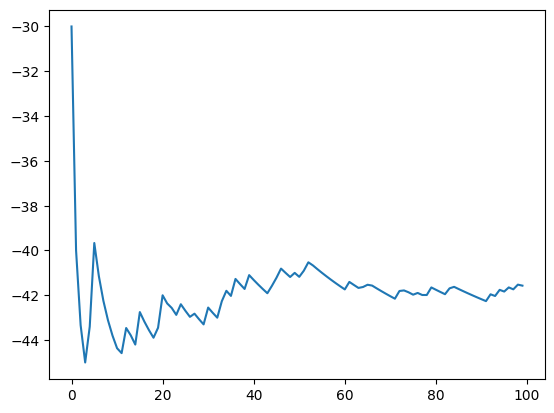

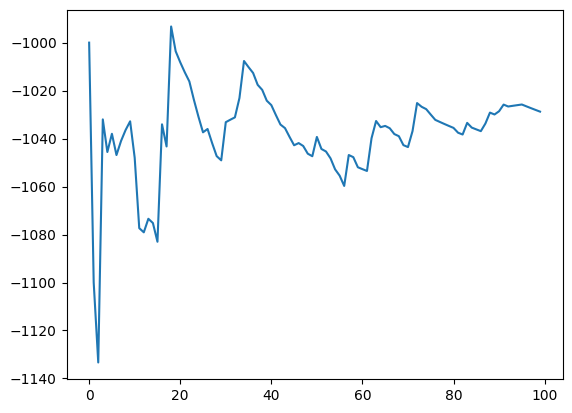

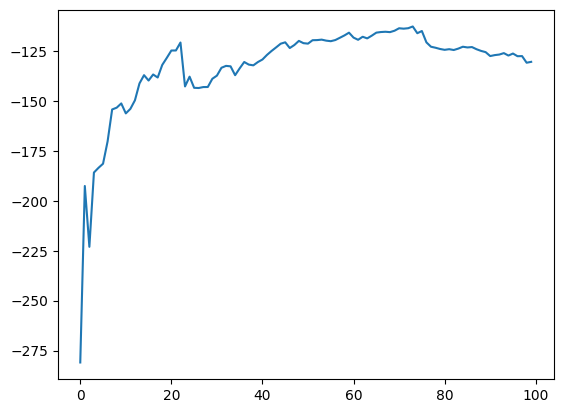

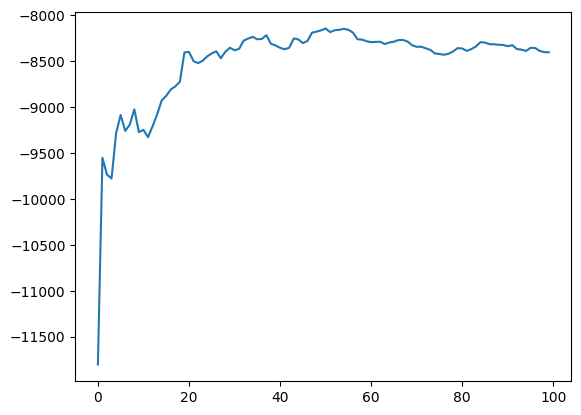

TypeError: __init__() missing 1 required positional argument: 'action_space'

In [4]:
#Task 2.1
def campaign(agent,environments):
    for env in environments:
        task = RLTask(env, agent)
        
        returns = task.interact(100)
        randInteract = plt.show(plt.plot(returns))

        # Clear the current figure to prevent overlap
        plt.close()

        randVisualise = task.visualize_episode(100)

emptyRoom = get_minihack_envirnment("empty-room")
lavaRoom = get_minihack_envirnment("room-with-lava")
monsterRoom = get_minihack_envirnment("room-with-monster")
cliffRoom = get_minihack_envirnment("cliff-minihack")

environments = [emptyRoom, lavaRoom, monsterRoom, cliffRoom] 

campaign(randAgent, environments)

#Monte Carlo On-policy
class monteCarlo():
    def __init__(self, id, action_space):
        self.id = id
        self.action_space = action_space

        # Flag that you can change for distinguishing whether the agent is used for learning or for testing.
        # You may want to disable some behaviour when not learning (e.g. no update rule, no exploration eps = 0, etc.)
        self.learning = True

mCarlo = monteCarlo(1,)
campaign(mCarlo, environments)

#Temporal Difference On-policy (SARSA)
class TD_onPolicy():
    def __init__(self, id, action_space):
        self.id = id
        self.action_space = action_space

TDon = TD_onPolicy(1,env.action_space)
campaign(TDon, environments)

#Temporal Difference Off-policy (Q-learning)
class TD_offPolicy():
    def __init__(self, id, action_space):
        self.id = id
        self.action_space = action_space

TDoff = TD_offPolicy(1)
campaign(TDoff, environments)





In [ ]:
#Task 2.2

In [ ]:
#Task 2.3
class dynaQ():
    def __init__(self, id, action_space):
        self.id = id
        self.action_space = action_space

dynaQ = dynaQ(1,)